# Tutorial de Redes Neurais com PyTorch

O objetivo deste notebook é apresentar as funções básicas para realizar uma análise utilizando redes neurais com PyTorch sobre uma base de dados fictícia.

Iremos utilizar ``x``, ``y`` e ``z`` como nossas features e utilizaremos ``label`` como nosso target.

Vamos importar nossos dados.

In [1]:
import pandas as pd

In [2]:
original_df = pd.read_csv('df_points.txt', index_col=0, delimiter='\t')

Vamos dar uma olhada nos nossos dados.

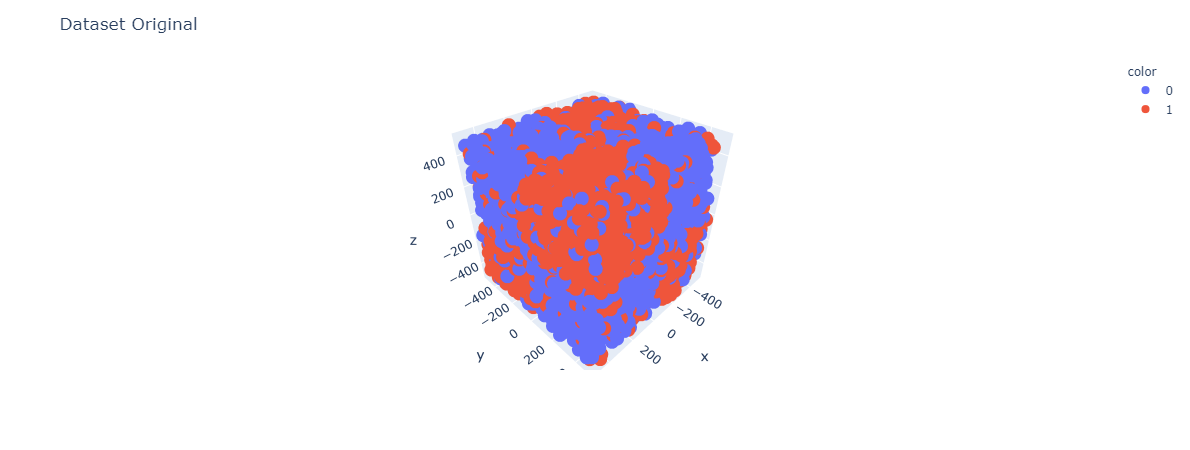

In [3]:
import plotly.express as px

fig = px.scatter_3d(original_df, x='x', y='y', z='z', color=original_df['label'].astype('int32').astype('str'))
fig.update_layout(title='Dataset Original')
fig.show()

## Pré-processamento dos dados

### Checagem por dados inválidos

Para verificar se há dados ausentes ou inválidos na nossa base, vamos dropar valores ``NaN``.

In [4]:
print(f'Quantidade de dados na base original: {original_df.shape[0]}')

Quantidade de dados na base original: 10000


In [5]:
dfPoints = original_df.dropna()

In [6]:
print(f'Quantidade de dados na base após a remoção dos valores inválidos: {dfPoints.shape[0]}')

Quantidade de dados na base após a remoção dos valores inválidos: 10000


Como podemos ver, não houve nenhum dado inválido.

### Normalização dos dados

Esta etapa redimensiona os dados para que os valores variem de 0 até 1. Sabe-se que essa técnica melhora o desempenho dos algoritmos de aprendizado de máquina. Vou utilizar o método min-max de normalização para executar esta etapa.

In [7]:
def normalize_dataframe(df):
    for column in df.columns:
        maxim = max(df[column])
        minim = min(df[column])
        
        df[column] = (df[column] - minim)/(maxim - minim)

In [8]:
normalize_dataframe(dfPoints)

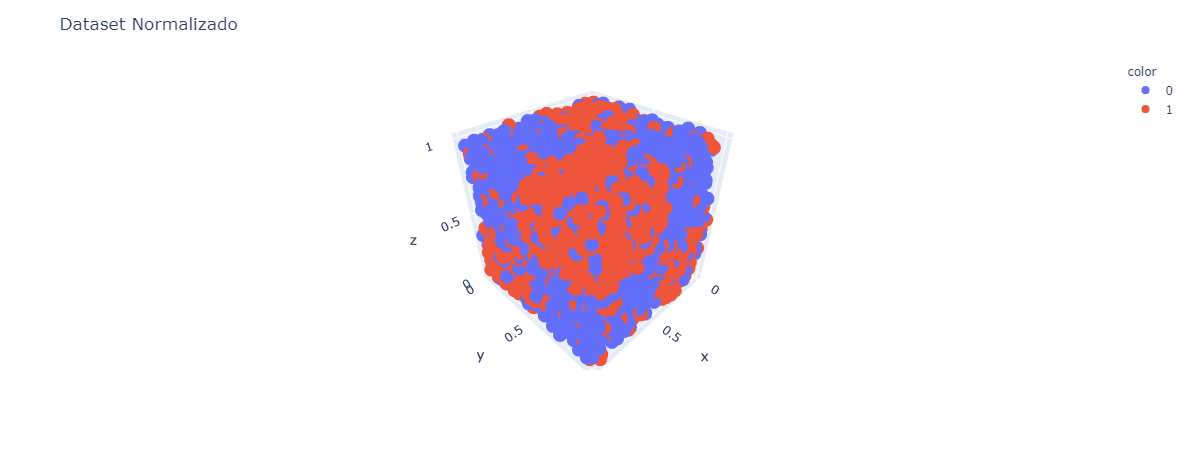

In [9]:
fig = px.scatter_3d(dfPoints, x='x', y='y', z='z', color=dfPoints['label'].astype('int32').astype('str'))
fig.update_layout(title='Dataset Normalizado')
fig.show()

In [10]:
dfPoints.head()

x         y         z  label
0  0.826559  0.689128  0.187780    0.0
1  0.185575  0.807457  0.320971    1.0
2  0.171649  0.681764  0.946429    1.0
3  0.351258  0.647153  0.472557    1.0
4  0.032747  0.750628  0.193511    1.0

## Conjuntos de treinamento, validação e teste

Essa etapa consiste em separar os dados em três conjuntos: treinamento, validação e teste.

- O conjunto de __treinamento__ será utilizado para treinar o modelo. Estes são os dados a partir dos quais o algoritmo aprenderá.
- O conjunto de __validação__ será utilizado para avaliar se a rede está ficando viciada (overfitting) no conjunto de treinamento. No momento em que a rede estiver diminuindo seus erros sobre o conjunto de treinamento, mas estiver aumentando seus erros sobre o conjunto de validação, o treinamento deverá ser interrompido. Ou seja, o ponto ideal do treinamento é aquele em que os erros sobre os conjuntos de treinamento e de validação são mínimos ao mesmo tempo.
- O conjunto de __teste__ será utilizado para avaliar o modelo. Como esse conjunto não será visto pelo algoritmo durante nenhuma etapa de treinamento, é uma boa maneira de avaliar a capacidade do modelo final em generalizar os padrões aprendidos.

Uma das proporções mais comumentes utilizadas na divisão é 0.7, 0.15, 0.15, ou seja, 70% dos dados são utilizados no conjunto de treinamento, 15% no conjunto de validação e 15% no conjunto de teste.

In [11]:
dfPoints.sort_values(by=['label'], inplace=True)

dfPoints['label'].value_counts()

1.0    5027
0.0    4973
Name: label, dtype: int64

A base de dados está razoavelmente equilibrada. Ela possui quase 50% dos dados para cada classe e, portanto, não há necessidade de realizar subamostragem nem sobreamostragem.

Dividiremos o conjunto de dados de maneira equilibrada entre as duas classes. Para isso, utilizaremos o [__StratifiedShuffleSplit__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

Primeiro, vamos pegar o conjunto de treinamento.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

X = dfPoints[['x', 'y', 'z']]
y = dfPoints['label']

# Vamos utilizar o parâmetro random_state para gerar sempre as mesmas divisões
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)

for train_index, remaining_index in sss.split(X, y):
    X_train, X_remaining = X.iloc[train_index], X.iloc[remaining_index]
    y_train, y_remaining = y.iloc[train_index], y.iloc[remaining_index]
    
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_remaining.reset_index(inplace=True, drop=True)
y_remaining.reset_index(inplace=True, drop=True)

In [13]:
print(f'Quantidade de elementos no conjunto de treinamento: {y_train.shape[0]}')

y_train.value_counts()

Quantidade de elementos no conjunto de treinamento: 7000


1.0    3519
0.0    3481
Name: label, dtype: int64

In [14]:
print(f'Quantidade de elementos restantes: {y_remaining.shape[0]}')

y_remaining.value_counts()

Quantidade de elementos restantes: 3000


1.0    1508
0.0    1492
Name: label, dtype: int64

Agora, vamos pegar os 30% restantes da base de dados e dividir entre os conjuntos de validação e de teste.

In [15]:
# Vamos utilizar o parâmetro random_state para gerar sempre as mesmas divisões
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(X_remaining, y_remaining)

for valid_index, test_index in sss.split(X_remaining, y_remaining):
    X_valid, X_test = X_remaining.iloc[valid_index], X_remaining.iloc[test_index]
    y_valid, y_test = y_remaining.iloc[valid_index], y_remaining.iloc[test_index]
    
X_valid.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [16]:
print(f'Quantidade de elementos no conjunto de validação: {y_valid.shape[0]}')
print(f'Quantidade de elementos no conjunto de teste: {y_test.shape[0]}')

Quantidade de elementos no conjunto de validação: 1500
Quantidade de elementos no conjunto de teste: 1500


In [17]:
y_valid.value_counts()

1.0    754
0.0    746
Name: label, dtype: int64

In [18]:
y_test.value_counts()

1.0    754
0.0    746
Name: label, dtype: int64

Vamos dar uma olhada nos conjuntos que acabamos de criar.

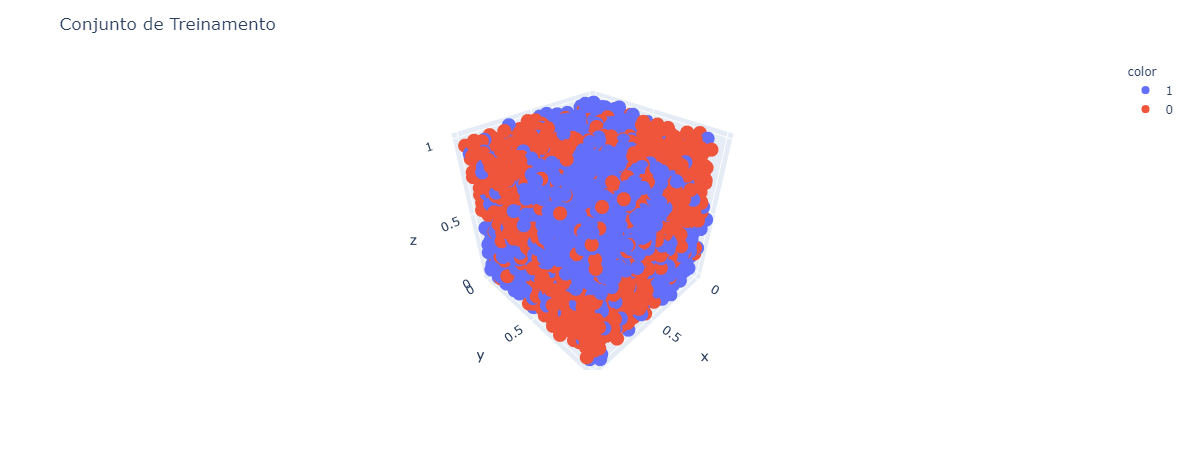

In [19]:
fig = px.scatter_3d(X_train, x='x', y='y', z='z', color=y_train.astype('int32').astype('str'))
fig.update_layout(title='Conjunto de Treinamento')
fig.show()

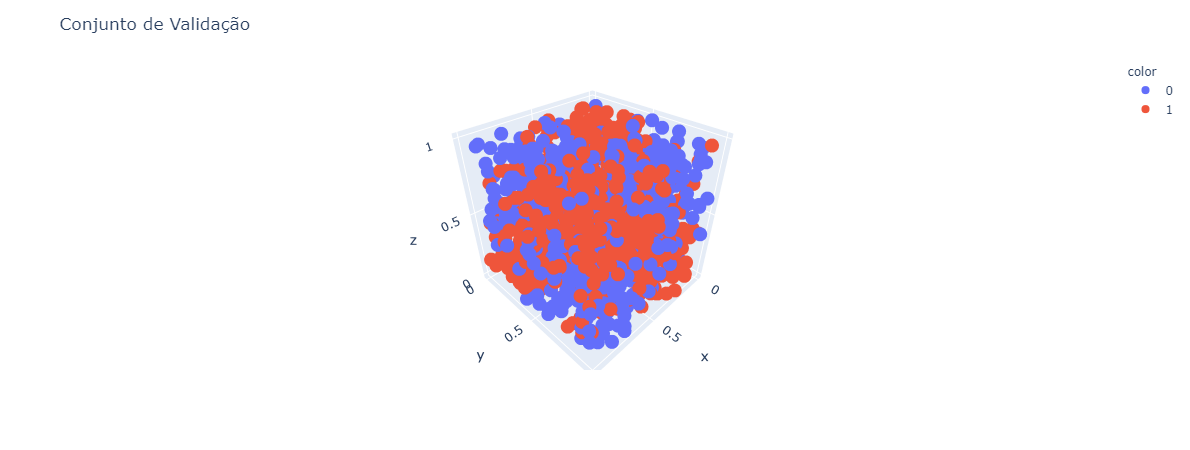

In [20]:
fig = px.scatter_3d(X_valid, x='x', y='y', z='z', color=y_valid.astype('int32').astype('str'))
fig.update_layout(title='Conjunto de Validação')
fig.show()

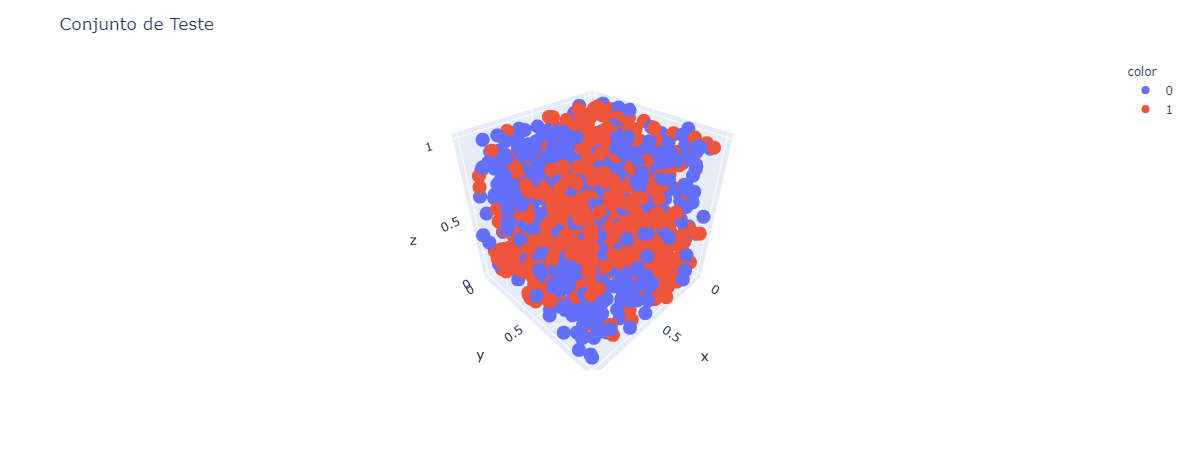

In [21]:
fig = px.scatter_3d(X_test, x='x', y='y', z='z', color=y_test.astype('int32').astype('str'))
fig.update_layout(title='Conjunto de Teste')
fig.show()

## Implementação da Rede Neural

Existem muitas arquiteturas diferentes para redes neurais, mas usaremos uma das mais simples aqui: uma rede feed-forward totalmente conectada. Nesta abordagem, a entrada para a rede é processada apenas em uma direção e todos os neurônios de uma camada são conectados a todos os neurônios da camada a seguir.

Uma explicação mais intuitiva sobre o que são redes neurais pode ser encontrada [aqui](https://www.quora.com/What-is-an-intuitive-explanation-for-neural-networks) e a parte principal é transcrita abaixo:

``Imagine you’re playing a game.

The game involves a complicated sentence of a long string of English words and the goal of the game is to translate it into Chinese. You have 3 people in Room A that could translate the English into Arabic, 3 people in Room B that could translate the Arabic into Chinese, and a judge in the last room.

Since the sentence is long, you break it into pieces and the translation work is distributed among your translators. English words are delivered to Room A, Arabic words are delivered from A to B, and Chinese is delivered to the judge. The judge will tell you how good your translation is. This is feed-forward, the English sentence is the input, your translators are neurons, the ways they translate are weights, the rooms are hidden layers, and the judge is the cost function. There are different ranges of vocabulary/expression for English, Arabic, and Chinese. To make sure that we can express everything in all these languages, we will simplify our sentences a little bit after each translation. This is the activation function. If your end result is bad (i.e. a part of the sentence doesn’t make sense), we go back through the rooms of translators to figure out who did a bad job with their pieces and try to correct it, but we only change it by a little so the whole sentence doesn’t become completely different. Now the translation gets a little better. This process is called back-propagation, the judge’s instruction interpreted by each translator are gradients in gradient descent, how small our changes are is the learning rate. Learning rate determines how drastically we change the meaning of the sentence every time.``

Para exemplificar, irei utilizar apenas duas camadas, sendo que a camada oculta possui 100 neurônios e a camada de saída possui apenas 2 neurônios (um para cada classe).

Para codificar os targets, iremos aplicar [``one-hot encoding``](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) em ``label``, gerando duas colunas como targets.

In [22]:
y_train = y_train.astype('int32')
y_valid = y_valid.astype('int32')
y_test = y_test.astype('int32')

y_train = pd.get_dummies(y_train, prefix='target')
y_valid = pd.get_dummies(y_valid, prefix='target')
y_test = pd.get_dummies(y_test, prefix='target')

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return x

input_dim = 3
nn_model = NeuralNet(input_dim)

Ao utilizar [Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html), nós estamos calculando a probabilidade de cada classe nas saídas. Note que, para isso, não colocamos uma função de ativação na camada de saída da rede, pois esse critério já aplica ``LogSoftMax`` nos valores recebidos.

Em relação à taxa de aprendizado, é algo que calibramos por meio de múltiplas tentativas. Os valores comumente mais utilizados são 0.1, 0.01 ou 0.001, mas outros valores também podem ser testados.

In [24]:
import numpy as np
import tqdm
import torch.optim as optim
import torch

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.001)

In [25]:
def train(model, n_epochs, optimizer, criterion, X_train, y_train, X_test, y_test):
    # initialize tracker for minimum validation loss
    model.float()
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        index = 0
        model.train()
        for original_data in X_train:
            original_target = y_train[index]
            target = (original_target == 1).nonzero()[0]
            
            data = torch.tensor(()).new_ones((1, 3))
            data[0] = original_data
            
            optimizer.zero_grad()
            
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += ((1 / (index + 1)) * (loss.data - train_loss))
            index += 1
        
        ######################
        # validate the model #
        ######################
        index = 0
        model.eval()
        for original_data in X_test:
            original_target = y_test[index]
            target = (original_target == 1).nonzero()[0]
            
            data = torch.tensor(()).new_ones((1, 3))
            data[0] = original_data

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (index + 1)) * (loss.data - valid_loss))
            index += 1
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            # print training/validation statistics
            print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}\tSaving model...'.format(
                epoch, 
                train_loss,
                valid_loss
                ), end='\r')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'best_model.pickle')
            
    return model

In [26]:
nn_model = train(nn_model, 20, optimizer, criterion,
                 torch.from_numpy(X_train.to_numpy()),
                 torch.from_numpy(y_train.to_numpy()),
                 torch.from_numpy(X_valid.to_numpy()),
                 torch.from_numpy(y_valid.to_numpy()))

In [27]:
def get_accuracy(model, X, y):

    model.eval()
    index = 0
    correct = 0
    for original_data in X:
        original_target = y[index]
        target = (original_target == 1).nonzero()[0]
        
        data = torch.tensor(()).new_ones((1, 3))
        data[0] = original_data
        
        output = model(data)
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output[0], 0)
        
        if pred == target:
            correct += 1
            
        index += 1
    
    return correct/index

In [28]:
nn_model.load_state_dict(torch.load('best_model.pickle'))

nn_accuracy = get_accuracy(nn_model,
                            torch.from_numpy(X_test.to_numpy()),
                            torch.from_numpy(y_test.to_numpy()))

print(f'Acurácia obtida pela rede neural: {nn_accuracy}')

Acurácia obtida pela rede neural: 0.724


Vamos construir a matriz de confusão.

In [29]:
nn_matrix = np.zeros((2, 2))

index = 0

for original_data in torch.from_numpy(X_test.to_numpy()):
    original_target = torch.from_numpy(y_test.to_numpy())[index]
    target = (original_target == 1).nonzero()[0]
    
    data = torch.tensor(()).new_ones((1, 3))
    data[0] = original_data
    
    output = nn_model(data)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output[0], 0)
    
    nn_matrix[int(target), int(pred)] += 1
    
    index += 1
    
nn_matrix

array([[490., 256.],
       [158., 596.]])

Como nosso modelo irá variar a cada vez que o executarmos, os valores abaixo são variáveis (são valores de uma das execuções realizadas anteriormente e devem ser consideradas apenas para exemplo).

|   |   | Predito |   |
|:-:|:-:|:-:|:-:|
|   |   | 0 | 1 |
| Target | 0 | 567 | 179 |
|   | 1 | 189 | 565 |

Mais algumas métricas:
- Sensibilidade (true positive rate): 0,75
- Especificidade (true negative rate): 0,76
- Precisão: 0,76
- Taxa de falsos positivos: 0,24
- Taxa de falsos negativos: 0,25

Brinque com os valores dos hiperparâmetros e tente obter a melhor rede possível. Altere taxa de aprendizado, quantidades de neurônios, quantidades de camadas, funções de ativação, épocas, otimizador etc. Dê o seu melhor!

Agora, é sua vez!